# Clustering with DBSCAN and HDBSCAN via Standard Convolution Pipeline

## DBSCAN PIPELINE

In [2]:
!pip install umap-learn wandb

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0=all, 1=filter INFO, 2=filter WARNING, 3=filter ERROR

import tensorflow as tf

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from umap import UMAP
from pathlib import Path
import wandb
from tqdm import tqdm

In [12]:
# ============= Configuration =============
FEATURES_PATH = "./autoencoder_numpy/tree_crown_latent_resnet34_finetuned.npy"
OUTPUT_DIR = Path("clustering_results")
OUTPUT_DIR.mkdir(exist_ok=True)

In [13]:
# UMAP parameters
UMAP_DIM = 50
UMAP_NEIGHBORS = 15
UMAP_MIN_DIST = 0.1

In [14]:
# Grid search parameters
EPS_VALUES = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
MIN_SAMPLES_VALUES = [3, 5, 7, 10, 15]

USE_WANDB = True  # Set to False to disable wandb

In [15]:
# ============= Initialize Wandb =============
if USE_WANDB:
    wandb.init(
        project="intreeligent-clustering-resnet34",
        name="dbscan-grid-search",
        config={
            "clustering_method": "DBSCAN",
            "umap_dim": UMAP_DIM,
            "umap_neighbors": UMAP_NEIGHBORS,
            "umap_min_dist": UMAP_MIN_DIST,
            "eps_values": EPS_VALUES,
            "min_samples_values": MIN_SAMPLES_VALUES,
            "features_path": str(FEATURES_PATH),
        }
    )

In [16]:
# ============= Load Features =============
print("Loading features...")
features = np.load(FEATURES_PATH)
print(f"✓ Loaded features shape: {features.shape}")
print(f"  {features.shape[0]} samples, {features.shape[1]} dimensions")

if USE_WANDB:
    wandb.log({
        "data/n_samples": features.shape[0],
        "data/feature_dim": features.shape[1],
    })

Loading features...
✓ Loaded features shape: (4274, 256)
  4274 samples, 256 dimensions


In [17]:
# ============= UMAP Dimensionality Reduction =============
print(f"\nReducing dimensions with UMAP to {UMAP_DIM}D...")
reducer = UMAP(
    n_components=UMAP_DIM,
    n_neighbors=UMAP_NEIGHBORS,
    min_dist=UMAP_MIN_DIST,
    random_state=42,
    verbose=True
)
reduced_features = reducer.fit_transform(features)
print(f"✓ Reduced features shape: {reduced_features.shape}")


Reducing dimensions with UMAP to 50D...
UMAP(n_components=50, n_jobs=1, random_state=42, verbose=True)
Sat Oct  4 06:13:17 2025 Construct fuzzy simplicial set
Sat Oct  4 06:13:17 2025 Finding Nearest Neighbors
Sat Oct  4 06:13:17 2025 Building RP forest with 8 trees


/opt/conda/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Sat Oct  4 06:13:21 2025 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	Stopping threshold met -- exiting after 4 iterations
Sat Oct  4 06:13:30 2025 Finished Nearest Neighbor Search
Sat Oct  4 06:13:33 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sat Oct  4 06:13:51 2025 Finished embedding
✓ Reduced features shape: (4274, 50)


In [18]:
# Save reduced features
np.save(OUTPUT_DIR / "reduced_features_default.npy", reduced_features)

In [19]:
# ============= Find Optimal Eps Guide =============
print(f"\nGenerating k-distance graphs for eps selection...")

fig, axes = plt.subplots(1, len(MIN_SAMPLES_VALUES), figsize=(20, 4))
if len(MIN_SAMPLES_VALUES) == 1:
    axes = [axes]

for idx, min_samp in enumerate(MIN_SAMPLES_VALUES):
    neighbors = NearestNeighbors(n_neighbors=min_samp)
    neighbors_fit = neighbors.fit(reduced_features)
    distances, _ = neighbors_fit.kneighbors(reduced_features)
    distances = np.sort(distances[:, -1], axis=0)
    
    axes[idx].plot(distances, linewidth=1.5)
    axes[idx].set_ylabel(f'{min_samp}-NN Distance', fontsize=10)
    axes[idx].set_xlabel('Points (sorted)', fontsize=10)
    axes[idx].set_title(f'min_samples={min_samp}', fontsize=11)
    axes[idx].grid(True, alpha=0.3)
    
    # Mark percentiles
    for pct in [90, 95]:
        val = np.percentile(distances, pct)
        axes[idx].axhline(y=val, color='r', linestyle='--', alpha=0.5, linewidth=1)
        axes[idx].text(len(distances)*0.7, val, f'{pct}th: {val:.2f}', fontsize=8)

plt.suptitle('K-distance Graphs for eps Selection (look for elbow points)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "kdistance_graphs.png", dpi=150, bbox_inches='tight')

if USE_WANDB:
    wandb.log({"eps_selection/kdistance_graphs": wandb.Image(fig)})
plt.close()


Generating k-distance graphs for eps selection...


In [20]:
# ============= Grid Search =============
print(f"\n{'='*60}")
print("GRID SEARCH: Testing all parameter combinations")
print(f"{'='*60}")

grid_results = []
best_silhouette = -1
best_params = None
best_clusters = None

total_combinations = len(EPS_VALUES) * len(MIN_SAMPLES_VALUES)
pbar = tqdm(total=total_combinations, desc="Grid Search")

for eps in EPS_VALUES:
    for min_samples in MIN_SAMPLES_VALUES:
        # Run DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        clusters = dbscan.fit_predict(reduced_features)
        
        # Calculate metrics
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        n_noise = list(clusters).count(-1)
        noise_pct = 100 * n_noise / len(clusters)
        
        # Silhouette score (only for non-noise points)
        silhouette = -1
        davies_bouldin = np.nan
        calinski_harabasz = np.nan
        
        if n_clusters > 1 and n_noise < len(clusters):
            mask = clusters >= 0
            if mask.sum() > 1:
                silhouette = silhouette_score(reduced_features[mask], clusters[mask])
                
                # Additional metrics
                if n_clusters > 1:
                    davies_bouldin = davies_bouldin_score(reduced_features[mask], clusters[mask])
                    calinski_harabasz = calinski_harabasz_score(reduced_features[mask], clusters[mask])
        
        # Store results
        result = {
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_pct': noise_pct,
            'silhouette': silhouette,
            'davies_bouldin': davies_bouldin,
            'calinski_harabasz': calinski_harabasz,
        }
        grid_results.append(result)
        
        # Log to wandb
        if USE_WANDB:
            wandb.log({
                f"grid_search/eps_{eps}_min_{min_samples}/n_clusters": n_clusters,
                f"grid_search/eps_{eps}_min_{min_samples}/n_noise": n_noise,
                f"grid_search/eps_{eps}_min_{min_samples}/noise_pct": noise_pct,
                f"grid_search/eps_{eps}_min_{min_samples}/silhouette": silhouette if silhouette != -1 else None,
                f"grid_search/eps_{eps}_min_{min_samples}/davies_bouldin": davies_bouldin if not np.isnan(davies_bouldin) else None,
                f"grid_search/eps_{eps}_min_{min_samples}/calinski_harabasz": calinski_harabasz if not np.isnan(calinski_harabasz) else None,
            })
        
        # Track best
        if silhouette > best_silhouette and n_clusters > 1:
            best_silhouette = silhouette
            best_params = {'eps': eps, 'min_samples': min_samples}
            best_clusters = clusters.copy()
        
        pbar.update(1)
        pbar.set_postfix({
            'eps': eps,
            'min_s': min_samples,
            'clusters': n_clusters,
            'sil': f'{silhouette:.3f}' if silhouette != -1 else 'N/A'
        })

pbar.close()


GRID SEARCH: Testing all parameter combinations


Grid Search: 100%|██████████| 35/35 [00:03<00:00, 10.23it/s, eps=1, min_s=15, clusters=1, sil=N/A]     


In [21]:
# ============= Grid Search Results Table =============
print(f"\n{'='*100}")
print("GRID SEARCH RESULTS")
print(f"{'='*100}")
print(f"{'eps':>6} {'min_s':>7} {'clusters':>9} {'noise':>7} {'noise%':>8} {'silhouette':>11} {'davies_b':>10} {'calinski':>12}")
print(f"{'-'*100}")

for result in sorted(grid_results, key=lambda x: x['silhouette'], reverse=True):
    print(f"{result['eps']:>6.1f} {result['min_samples']:>7d} {result['n_clusters']:>9d} "
          f"{result['n_noise']:>7d} {result['noise_pct']:>7.1f}% "
          f"{result['silhouette']:>10.3f} "
          f"{result['davies_bouldin']:>10.3f} "
          f"{result['calinski_harabasz']:>12.1f}")

print(f"\n✓ Best parameters: eps={best_params['eps']}, min_samples={best_params['min_samples']}")
print(f"  Silhouette score: {best_silhouette:.3f}")

# Save grid search results
np.save(OUTPUT_DIR / "grid_search_results_conv.npy", grid_results)


GRID SEARCH RESULTS
   eps   min_s  clusters   noise   noise%  silhouette   davies_b     calinski
----------------------------------------------------------------------------------------------------
   0.3      15        36    1293    30.3%      0.240      0.826       6367.0
   0.4       3         2       0     0.0%     -0.103      0.972          3.8
   0.3      10        24     436    10.2%     -0.119      1.411       3646.6
   0.3       7         4     178     4.2%     -0.198      0.987          5.7
   0.3       5         4      83     1.9%     -0.621      0.993          6.6
   0.3       3         5      41     1.0%     -0.663      1.000          3.7
   0.4       5         1       5     0.1%     -1.000        nan          nan
   0.4       7         1       6     0.1%     -1.000        nan          nan
   0.4      10         1      13     0.3%     -1.000        nan          nan
   0.4      15         1      58     1.4%     -1.000        nan          nan
   0.5       3         1      

In [22]:
# ============= Grid Search Results Table =============
print(f"\n{'='*100}")
print("GRID SEARCH RESULTS")
print(f"{'='*100}")
print(f"{'eps':>6} {'min_s':>7} {'clusters':>9} {'noise':>7} {'noise%':>8} {'silhouette':>11} {'davies_b':>10} {'calinski':>12}")
print(f"{'-'*100}")

for result in sorted(grid_results, key=lambda x: x['silhouette'], reverse=True):
    print(f"{result['eps']:>6.1f} {result['min_samples']:>7d} {result['n_clusters']:>9d} "
          f"{result['n_noise']:>7d} {result['noise_pct']:>7.1f}% "
          f"{result['silhouette']:>10.3f} "
          f"{result['davies_bouldin']:>10.3f} "
          f"{result['calinski_harabasz']:>12.1f}")

print(f"\n✓ Best parameters: eps={best_params['eps']}, min_samples={best_params['min_samples']}")
print(f"  Silhouette score: {best_silhouette:.3f}")

# Save grid search results
np.save(OUTPUT_DIR / "grid_search_results.npy", grid_results)

# ============= Visualize Grid Search Results =============
print("\nGenerating grid search visualizations...")

# Create heatmaps for each metric
metrics = ['n_clusters', 'noise_pct', 'silhouette', 'davies_bouldin', 'calinski_harabasz']
metric_names = ['Number of Clusters', 'Noise %', 'Silhouette Score', 'Davies-Bouldin Score', 'Calinski-Harabasz Score']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    # Create matrix for heatmap
    matrix = np.zeros((len(MIN_SAMPLES_VALUES), len(EPS_VALUES)))
    
    for i, min_samp in enumerate(MIN_SAMPLES_VALUES):
        for j, eps in enumerate(EPS_VALUES):
            # Find corresponding result
            for result in grid_results:
                if result['eps'] == eps and result['min_samples'] == min_samp:
                    val = result[metric]
                    if metric == 'silhouette' and val == -1:
                        val = np.nan
                    matrix[i, j] = val
                    break
    
    # Plot heatmap
    im = axes[idx].imshow(matrix, aspect='auto', cmap='viridis' if metric != 'davies_bouldin' else 'viridis_r')
    axes[idx].set_xticks(range(len(EPS_VALUES)))
    axes[idx].set_yticks(range(len(MIN_SAMPLES_VALUES)))
    axes[idx].set_xticklabels([f'{e:.1f}' for e in EPS_VALUES])
    axes[idx].set_yticklabels([f'{m}' for m in MIN_SAMPLES_VALUES])
    axes[idx].set_xlabel('eps', fontsize=11)
    axes[idx].set_ylabel('min_samples', fontsize=11)
    axes[idx].set_title(name, fontsize=12, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[idx])
    cbar.ax.tick_params(labelsize=9)
    
    # Add text annotations
    for i in range(len(MIN_SAMPLES_VALUES)):
        for j in range(len(EPS_VALUES)):
            val = matrix[i, j]
            if not np.isnan(val):
                text_color = 'white' if val > (np.nanmax(matrix) + np.nanmin(matrix)) / 2 else 'black'
                if metric in ['n_clusters', 'noise_pct']:
                    text = f'{val:.0f}'
                else:
                    text = f'{val:.2f}'
                axes[idx].text(j, i, text, ha='center', va='center', 
                             color=text_color, fontsize=8, fontweight='bold')

# Mark best params on silhouette plot
if best_params:
    best_i = MIN_SAMPLES_VALUES.index(best_params['min_samples'])
    best_j = EPS_VALUES.index(best_params['eps'])
    axes[2].scatter(best_j, best_i, s=300, c='red', marker='*', 
                   edgecolors='white', linewidths=2, zorder=10)

# Remove extra subplot
axes[5].remove()

plt.suptitle('DBSCAN Grid Search Results', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "grid_search_heatmaps.png", dpi=150, bbox_inches='tight')

if USE_WANDB:
    wandb.log({"grid_search/heatmaps": wandb.Image(fig)})
plt.close()


GRID SEARCH RESULTS
   eps   min_s  clusters   noise   noise%  silhouette   davies_b     calinski
----------------------------------------------------------------------------------------------------
   0.3      15        36    1293    30.3%      0.240      0.826       6367.0
   0.4       3         2       0     0.0%     -0.103      0.972          3.8
   0.3      10        24     436    10.2%     -0.119      1.411       3646.6
   0.3       7         4     178     4.2%     -0.198      0.987          5.7
   0.3       5         4      83     1.9%     -0.621      0.993          6.6
   0.3       3         5      41     1.0%     -0.663      1.000          3.7
   0.4       5         1       5     0.1%     -1.000        nan          nan
   0.4       7         1       6     0.1%     -1.000        nan          nan
   0.4      10         1      13     0.3%     -1.000        nan          nan
   0.4      15         1      58     1.4%     -1.000        nan          nan
   0.5       3         1      

In [23]:
# ============= Analyze Best Clustering =============
print(f"\n{'='*60}")
print("BEST CLUSTERING RESULTS")
print(f"{'='*60}")

n_clusters_best = len(set(best_clusters)) - (1 if -1 in best_clusters else 0)
n_noise_best = list(best_clusters).count(-1)

print(f"Parameters: eps={best_params['eps']}, min_samples={best_params['min_samples']}")
print(f"  Number of clusters: {n_clusters_best}")
print(f"  Noise points: {n_noise_best} ({100*n_noise_best/len(best_clusters):.1f}%)")
print(f"  Silhouette score: {best_silhouette:.3f}")

if n_clusters_best > 0:
    cluster_sizes = np.bincount(best_clusters[best_clusters >= 0])
    print(f"\nCluster sizes:")
    for i, size in enumerate(cluster_sizes):
        print(f"  Cluster {i}: {size} samples")

# Save best clustering
np.save(OUTPUT_DIR / "clusters_best.npy", best_clusters)

if USE_WANDB:
    wandb.log({
        "best/eps": best_params['eps'],
        "best/min_samples": best_params['min_samples'],
        "best/n_clusters": n_clusters_best,
        "best/n_noise": n_noise_best,
        "best/noise_pct": 100*n_noise_best/len(best_clusters),
        "best/silhouette": best_silhouette,
    })


BEST CLUSTERING RESULTS
Parameters: eps=0.3, min_samples=15
  Number of clusters: 36
  Noise points: 1293 (30.3%)
  Silhouette score: 0.240

Cluster sizes:
  Cluster 0: 338 samples
  Cluster 1: 304 samples
  Cluster 2: 41 samples
  Cluster 3: 447 samples
  Cluster 4: 67 samples
  Cluster 5: 26 samples
  Cluster 6: 61 samples
  Cluster 7: 59 samples
  Cluster 8: 78 samples
  Cluster 9: 111 samples
  Cluster 10: 15 samples
  Cluster 11: 125 samples
  Cluster 12: 168 samples
  Cluster 13: 75 samples
  Cluster 14: 20 samples
  Cluster 15: 23 samples
  Cluster 16: 51 samples
  Cluster 17: 284 samples
  Cluster 18: 161 samples
  Cluster 19: 26 samples
  Cluster 20: 19 samples
  Cluster 21: 32 samples
  Cluster 22: 26 samples
  Cluster 23: 24 samples
  Cluster 24: 28 samples
  Cluster 25: 27 samples
  Cluster 26: 17 samples
  Cluster 27: 84 samples
  Cluster 28: 31 samples
  Cluster 29: 27 samples
  Cluster 30: 15 samples
  Cluster 31: 48 samples
  Cluster 32: 20 samples
  Cluster 33: 18 sam

In [24]:
# ============= Visualize Best Clustering =============
print("\nGenerating best clustering visualizations...")

# 2D UMAP for visualization
reducer_2d = UMAP(n_components=2, n_neighbors=UMAP_NEIGHBORS, 
                  min_dist=UMAP_MIN_DIST, random_state=42)
features_2d = reducer_2d.fit_transform(features)

# Main clustering visualization
fig, ax = plt.subplots(figsize=(14, 10))

if n_noise_best > 0:
    noise_mask = best_clusters == -1
    ax.scatter(features_2d[noise_mask, 0], features_2d[noise_mask, 1],
              c='lightgray', s=15, alpha=0.4, label=f'Noise (n={n_noise_best})', 
              edgecolors='none')

if n_clusters_best > 0:
    cluster_mask = best_clusters >= 0
    scatter = ax.scatter(features_2d[cluster_mask, 0], features_2d[cluster_mask, 1],
                        c=best_clusters[cluster_mask], cmap='tab20', s=20, alpha=0.7, 
                        edgecolors='none')
    cbar = plt.colorbar(scatter, ax=ax, label="Cluster ID")
    cbar.ax.tick_params(labelsize=10)

ax.set_xlabel("UMAP Dimension 1", fontsize=12)
ax.set_ylabel("UMAP Dimension 2", fontsize=12)
ax.set_title(f"Best DBSCAN Clustering (eps={best_params['eps']}, min_samples={best_params['min_samples']})\n"
            f"{n_clusters_best} clusters, {n_noise_best} noise points, Silhouette={best_silhouette:.3f}", 
            fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "best_clustering_umap.png", dpi=150)

if USE_WANDB:
    wandb.log({"best/umap_visualization": wandb.Image(fig)})
plt.close()

# Cluster distribution
if n_clusters_best > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart
    axes[0].bar(range(len(cluster_sizes)), cluster_sizes, color='steelblue', alpha=0.7)
    axes[0].set_xlabel("Cluster ID", fontsize=12)
    axes[0].set_ylabel("Number of Samples", fontsize=12)
    axes[0].set_title(f"Cluster Size Distribution", fontsize=12)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Pie chart
    sizes = list(cluster_sizes) + ([n_noise_best] if n_noise_best > 0 else [])
    labels = [f"C{i}" for i in range(n_clusters_best)] + (["Noise"] if n_noise_best > 0 else [])
    colors = plt.cm.tab20.colors[:n_clusters_best] + (('lightgray',) if n_noise_best > 0 else ())
    
    wedges, texts, autotexts = axes[1].pie(sizes, labels=labels, autopct='%1.1f%%',
                                            colors=colors, startangle=90)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(9)
        autotext.set_weight('bold')
    axes[1].set_title(f"Cluster Proportions", fontsize=12)
    
    plt.suptitle(f"Best Clustering Statistics", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "best_clustering_distribution.png", dpi=150)
    
    if USE_WANDB:
        wandb.log({"best/distribution": wandb.Image(fig)})
    plt.close()


Generating best clustering visualizations...


/opt/conda/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [25]:
# ============= Comparison Plot: Show Multiple Good Options =============
print("\nGenerating comparison of top clustering results...")

# Get top 6 results by silhouette
top_results = sorted([r for r in grid_results if r['silhouette'] > 0], 
                     key=lambda x: x['silhouette'], reverse=True)[:6]

if len(top_results) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, result in enumerate(top_results):
        # Re-run clustering for visualization
        dbscan = DBSCAN(eps=result['eps'], min_samples=result['min_samples'], n_jobs=-1)
        clusters_viz = dbscan.fit_predict(reduced_features)
        
        n_clusters_viz = result['n_clusters']
        n_noise_viz = result['n_noise']
        
        # Plot
        if n_noise_viz > 0:
            noise_mask = clusters_viz == -1
            axes[idx].scatter(features_2d[noise_mask, 0], features_2d[noise_mask, 1],
                            c='lightgray', s=5, alpha=0.3, edgecolors='none')
        
        if n_clusters_viz > 0:
            cluster_mask = clusters_viz >= 0
            axes[idx].scatter(features_2d[cluster_mask, 0], features_2d[cluster_mask, 1],
                            c=clusters_viz[cluster_mask], cmap='tab20', s=8, alpha=0.6,
                            edgecolors='none')
        
        axes[idx].set_xlabel("UMAP 1", fontsize=9)
        axes[idx].set_ylabel("UMAP 2", fontsize=9)
        axes[idx].set_title(f"eps={result['eps']}, min_s={result['min_samples']}\n"
                          f"{n_clusters_viz} clusters, sil={result['silhouette']:.3f}",
                          fontsize=10)
        axes[idx].grid(True, alpha=0.2)
    
    plt.suptitle('Top 6 Clustering Results by Silhouette Score', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "top_clustering_comparison.png", dpi=150)
    
    if USE_WANDB:
        wandb.log({"comparison/top_6_results": wandb.Image(fig)})
    plt.close()



Generating comparison of top clustering results...


In [26]:
# ============= Save Summary Report =============
print("\nSaving summary report...")

with open(OUTPUT_DIR / "clustering_report.txt", "w") as f:
    f.write("="*80 + "\n")
    f.write("DBSCAN CLUSTERING - GRID SEARCH REPORT\n")
    f.write("="*80 + "\n\n")
    
    f.write("CONFIGURATION\n")
    f.write("-"*80 + "\n")
    f.write(f"Features path: {FEATURES_PATH}\n")
    f.write(f"Number of samples: {features.shape[0]}\n")
    f.write(f"Original feature dimension: {features.shape[1]}\n")
    f.write(f"UMAP reduced dimension: {UMAP_DIM}\n")
    f.write(f"UMAP neighbors: {UMAP_NEIGHBORS}\n")
    f.write(f"UMAP min_dist: {UMAP_MIN_DIST}\n\n")
    
    f.write("GRID SEARCH PARAMETERS\n")
    f.write("-"*80 + "\n")
    f.write(f"eps values tested: {EPS_VALUES}\n")
    f.write(f"min_samples values tested: {MIN_SAMPLES_VALUES}\n")
    f.write(f"Total combinations: {len(grid_results)}\n\n")
    
    f.write("BEST CLUSTERING RESULT\n")
    f.write("-"*80 + "\n")
    f.write(f"Parameters: eps={best_params['eps']}, min_samples={best_params['min_samples']}\n")
    f.write(f"Number of clusters: {n_clusters_best}\n")
    f.write(f"Noise points: {n_noise_best} ({100*n_noise_best/len(best_clusters):.1f}%)\n")
    f.write(f"Silhouette score: {best_silhouette:.3f}\n\n")
    
    if n_clusters_best > 0:
        f.write("Cluster sizes:\n")
        for i, size in enumerate(cluster_sizes):
            f.write(f"  Cluster {i}: {size} samples\n")
        f.write("\n")
    
    f.write("TOP 10 RESULTS BY SILHOUETTE SCORE\n")
    f.write("-"*80 + "\n")
    f.write(f"{'Rank':>4} {'eps':>6} {'min_s':>7} {'clusters':>9} {'noise%':>8} {'silhouette':>11}\n")
    f.write("-"*80 + "\n")
    
    top_10 = sorted([r for r in grid_results if r['silhouette'] > 0], 
                    key=lambda x: x['silhouette'], reverse=True)[:10]
    
    for rank, result in enumerate(top_10, 1):
        f.write(f"{rank:>4} {result['eps']:>6.1f} {result['min_samples']:>7d} "
               f"{result['n_clusters']:>9d} {result['noise_pct']:>7.1f}% "
               f"{result['silhouette']:>10.3f}\n")

print(f"✓ Saved report to: {OUTPUT_DIR / 'clustering_report.txt'}")


Saving summary report...
✓ Saved report to: clustering_results/clustering_report.txt


In [27]:
# ============= Save Artifacts to Wandb =============
if USE_WANDB:
    print("\nSaving artifacts to wandb...")
    wandb.save(str(OUTPUT_DIR / "reduced_features.npy"))
    wandb.save(str(OUTPUT_DIR / "clusters_best.npy"))
    wandb.save(str(OUTPUT_DIR / "grid_search_results.npy"))
    wandb.save(str(OUTPUT_DIR / "clustering_report.txt"))
    
    # Create table for wandb
    table = wandb.Table(
        columns=["eps", "min_samples", "n_clusters", "n_noise", "noise_pct", 
                "silhouette", "davies_bouldin", "calinski_harabasz"],
        data=[[r['eps'], r['min_samples'], r['n_clusters'], r['n_noise'], 
               r['noise_pct'], r['silhouette'], r['davies_bouldin'], r['calinski_harabasz']]
              for r in grid_results]
    )
    wandb.log({"grid_search/results_table": table})
    
    wandb.finish()
    print("✓ Wandb logging complete!")


Saving artifacts to wandb...


best/eps,▁
best/min_samples,▁
best/n_clusters,▁
best/n_noise,▁
best/noise_pct,▁
best/silhouette,▁
data/feature_dim,▁
data/n_samples,▁
grid_search/eps_0.3_min_10/calinski_harabasz,▁
grid_search/eps_0.3_min_10/davies_bouldin,▁
+121,...


✓ Wandb logging complete!


In [28]:
# ============= Summary =============
print(f"\n{'='*80}")
print("CLUSTERING COMPLETE!")
print(f"{'='*80}")
print(f"All results saved to: {OUTPUT_DIR}")
print(f"\nFiles created:")
print(f"  • reduced_features.npy")
print(f"  • clusters_best.npy")
print(f"  • grid_search_results.npy")
print(f"  • clustering_report.txt")
print(f"  • kdistance_graphs.png")
print(f"  • grid_search_heatmaps.png")
print(f"  • best_clustering_umap.png")
print(f"  • best_clustering_distribution.png")
print(f"  • top_clustering_comparison.png")
print(f"\n✓ Done! Check your wandb dashboard for interactive visualizations.")


CLUSTERING COMPLETE!
All results saved to: clustering_results

Files created:
  • reduced_features.npy
  • clusters_best.npy
  • grid_search_results.npy
  • clustering_report.txt
  • kdistance_graphs.png
  • grid_search_heatmaps.png
  • best_clustering_umap.png
  • best_clustering_distribution.png
  • top_clustering_comparison.png

✓ Done! Check your wandb dashboard for interactive visualizations.


## HDBSCAN Pipeline

In [35]:
!pip install hdbscan

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from umap import UMAP
from pathlib import Path
import wandb
from tqdm import tqdm

In [29]:
# ============= Configuration =============
FEATURES_PATH = "./autoencoder_numpy/tree_crown_latent_resnet34_finetuned.npy"
OUTPUT_DIR = Path("clustering_results_hdbscan")
OUTPUT_DIR.mkdir(exist_ok=True)

In [30]:
# UMAP parameters
UMAP_DIM = 50
UMAP_NEIGHBORS = 15
UMAP_MIN_DIST = 0.1

# Grid search parameters
MIN_CLUSTER_SIZE_VALUES = [5, 10, 15, 20, 30, 50, 100]
MIN_SAMPLES_VALUES = [1, 3, 5, 10, 15]

USE_WANDB = True  # Set to False to disable wandb

In [31]:
# ============= Initialize Wandb =============
if USE_WANDB:
    wandb.init(
        project="intreeligent-clustering-resnet34",
        name="hdbscan-grid-search",
        config={
            "clustering_method": "HDBSCAN",
            "umap_dim": UMAP_DIM,
            "umap_neighbors": UMAP_NEIGHBORS,
            "umap_min_dist": UMAP_MIN_DIST,
            "min_cluster_size_values": MIN_CLUSTER_SIZE_VALUES,
            "min_samples_values": MIN_SAMPLES_VALUES,
            "features_path": str(FEATURES_PATH),
        }
    )

In [32]:
# ============= Load Features =============
print("Loading features...")
features = np.load(FEATURES_PATH)
print(f"✓ Loaded features shape: {features.shape}")
print(f"  {features.shape[0]} samples, {features.shape[1]} dimensions")

if USE_WANDB:
    wandb.log({
        "data/n_samples": features.shape[0],
        "data/feature_dim": features.shape[1],
    })

Loading features...
✓ Loaded features shape: (4274, 256)
  4274 samples, 256 dimensions


In [33]:
# ============= UMAP Dimensionality Reduction =============
print(f"\nReducing dimensions with UMAP to {UMAP_DIM}D...")
reducer = UMAP(
    n_components=UMAP_DIM,
    n_neighbors=UMAP_NEIGHBORS,
    min_dist=UMAP_MIN_DIST,
    random_state=42,
    verbose=True
)
reduced_features = reducer.fit_transform(features)
print(f"✓ Reduced features shape: {reduced_features.shape}")

# Save reduced features
np.save(OUTPUT_DIR / "reduced_features_default.npy", reduced_features)


Reducing dimensions with UMAP to 50D...
UMAP(n_components=50, n_jobs=1, random_state=42, verbose=True)
Sat Oct  4 06:17:00 2025 Construct fuzzy simplicial set
Sat Oct  4 06:17:00 2025 Finding Nearest Neighbors
Sat Oct  4 06:17:00 2025 Building RP forest with 8 trees
Sat Oct  4 06:17:00 2025 NN descent for 12 iterations
	 1  /  12
	 2  /  12


/opt/conda/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


	 3  /  12
	 4  /  12
	Stopping threshold met -- exiting after 4 iterations
Sat Oct  4 06:17:01 2025 Finished Nearest Neighbor Search
Sat Oct  4 06:17:01 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sat Oct  4 06:17:19 2025 Finished embedding
✓ Reduced features shape: (4274, 50)


In [38]:
# ============= Grid Search =============
print(f"\n{'='*60}")
print("GRID SEARCH: Testing all parameter combinations")
print(f"{'='*60}")

grid_results = []
best_score = -1
best_params = None

total_combinations = len(MIN_CLUSTER_SIZE_VALUES) * len(MIN_SAMPLES_VALUES)
pbar = tqdm(total=total_combinations, desc="Grid Search")

for min_cluster_size in MIN_CLUSTER_SIZE_VALUES:
    for min_samples in MIN_SAMPLES_VALUES:
        # Run HDBSCAN (without tree generation for speed)
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            cluster_selection_method='eom',
            prediction_data=True
        )
        clusters = clusterer.fit_predict(reduced_features)
        
        # Calculate metrics
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        n_noise = list(clusters).count(-1)
        noise_pct = 100 * n_noise / len(clusters)
        
        # HDBSCAN-specific metrics
        cluster_persistence = clusterer.cluster_persistence_ if hasattr(clusterer, 'cluster_persistence_') else None
        relative_validity = clusterer.relative_validity_ if hasattr(clusterer, 'relative_validity_') else None
        
        # Cluster probabilities
        probabilities = clusterer.probabilities_
        avg_prob = probabilities[clusters >= 0].mean() if n_clusters > 0 else 0
        
        # Standard clustering metrics (only for non-noise points)
        silhouette = -1
        davies_bouldin = np.nan
        calinski_harabasz = np.nan
        
        if n_clusters > 1 and n_noise < len(clusters):
            mask = clusters >= 0
            if mask.sum() > 1:
                silhouette = silhouette_score(reduced_features[mask], clusters[mask])
                
                if n_clusters > 1:
                    davies_bouldin = davies_bouldin_score(reduced_features[mask], clusters[mask])
                    calinski_harabasz = calinski_harabasz_score(reduced_features[mask], clusters[mask])
        
        # Store results
        result = {
            'min_cluster_size': min_cluster_size,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_pct': noise_pct,
            'silhouette': silhouette,
            'davies_bouldin': davies_bouldin,
            'calinski_harabasz': calinski_harabasz,
            'relative_validity': relative_validity if relative_validity else np.nan,
            'avg_probability': avg_prob,
            'cluster_persistence': cluster_persistence.tolist() if cluster_persistence is not None else None,
        }
        grid_results.append(result)
        
        # Log to wandb
        if USE_WANDB:
            wandb.log({
                f"grid_search/mcs_{min_cluster_size}_ms_{min_samples}/n_clusters": n_clusters,
                f"grid_search/mcs_{min_cluster_size}_ms_{min_samples}/n_noise": n_noise,
                f"grid_search/mcs_{min_cluster_size}_ms_{min_samples}/noise_pct": noise_pct,
                f"grid_search/mcs_{min_cluster_size}_ms_{min_samples}/silhouette": silhouette if silhouette != -1 else None,
                f"grid_search/mcs_{min_cluster_size}_ms_{min_samples}/relative_validity": relative_validity if relative_validity else None,
                f"grid_search/mcs_{min_cluster_size}_ms_{min_samples}/avg_probability": avg_prob,
            })
        
        # Track best (using relative validity which is HDBSCAN's internal score)
        score = relative_validity if relative_validity and not np.isnan(relative_validity) else silhouette
        if score > best_score and n_clusters > 1:
            best_score = score
            best_params = {'min_cluster_size': min_cluster_size, 'min_samples': min_samples}
        
        pbar.update(1)
        pbar.set_postfix({
            'mcs': min_cluster_size,
            'min_s': min_samples,
            'clusters': n_clusters,
            'rel_val': f'{relative_validity:.3f}' if relative_validity else 'N/A'
        })

pbar.close()


GRID SEARCH: Testing all parameter combinations


Grid Search:   0%|          | 0/35 [00:16<?, ?it/s]
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Grid Search:   3%|▎         | 1/35 [00:00<00:24,  1.41it/s, mcs=5, min_s=1, clusters=290, rel_val=N/A]/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Grid Search:   6%|▌         | 2/35 [00:01<00:21,  1.55it/s, mcs=5,

In [39]:
# ============= Regenerate Best Clustering with Tree =============
print(f"\nRegenerating best clustering with visualization data...")
best_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=best_params['min_cluster_size'],
    min_samples=best_params['min_samples'],
    cluster_selection_method='eom',
    prediction_data=True,
    gen_min_span_tree=True  # Enable tree generation for visualization
)
best_clusters = best_clusterer.fit_predict(reduced_features)
best_probabilities = best_clusterer.probabilities_
print("✓ Best clustering regenerated with tree data")


Regenerating best clustering with visualization data...


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✓ Best clustering regenerated with tree data


In [40]:
# ============= Grid Search Results Table =============
print(f"\n{'='*110}")
print("GRID SEARCH RESULTS")
print(f"{'='*110}")
print(f"{'min_cls':>8} {'min_s':>7} {'clusters':>9} {'noise':>7} {'noise%':>8} {'silhouette':>11} {'rel_valid':>10} {'avg_prob':>9}")
print(f"{'-'*110}")

for result in sorted(grid_results, key=lambda x: x.get('relative_validity', -1) if not np.isnan(x.get('relative_validity', -1)) else -1, reverse=True):
    print(f"{result['min_cluster_size']:>8d} {result['min_samples']:>7d} {result['n_clusters']:>9d} "
          f"{result['n_noise']:>7d} {result['noise_pct']:>7.1f}% "
          f"{result['silhouette']:>10.3f} "
          f"{result['relative_validity']:>10.3f} "
          f"{result['avg_probability']:>9.3f}")

print(f"\n✓ Best parameters: min_cluster_size={best_params['min_cluster_size']}, min_samples={best_params['min_samples']}")
print(f"  Best score (relative validity): {best_score:.3f}")

# Save grid search results
np.save(OUTPUT_DIR / "grid_search_results_default.npy", grid_results)


GRID SEARCH RESULTS
 min_cls   min_s  clusters   noise   noise%  silhouette  rel_valid  avg_prob
--------------------------------------------------------------------------------------------------------------
       5       1       290    1128    26.4%      0.337        nan     0.909
       5       3       183    1564    36.6%      0.374        nan     0.917
       5       5       120    1777    41.6%      0.362        nan     0.919
       5      10        52    1952    45.7%      0.228        nan     0.951
       5      15        34    2028    47.4%      0.210        nan     0.948
      10       1       116    1007    23.6%      0.276        nan     0.939
      10       3       100    1563    36.6%      0.362        nan     0.932
      10       5        82    1886    44.1%      0.381        nan     0.921
      10      10        43    1971    46.1%      0.260        nan     0.952
      10      15        27    2144    50.2%      0.401        nan     0.929
      15       1        81     

In [41]:
# ============= Visualize Grid Search Results =============
print("\nGenerating grid search visualizations...")

# Create heatmaps for each metric
metrics = ['n_clusters', 'noise_pct', 'silhouette', 'relative_validity', 'avg_probability']
metric_names = ['Number of Clusters', 'Noise %', 'Silhouette Score', 'Relative Validity', 'Avg Probability']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    # Create matrix for heatmap
    matrix = np.zeros((len(MIN_SAMPLES_VALUES), len(MIN_CLUSTER_SIZE_VALUES)))
    
    for i, min_samp in enumerate(MIN_SAMPLES_VALUES):
        for j, min_cls in enumerate(MIN_CLUSTER_SIZE_VALUES):
            # Find corresponding result
            for result in grid_results:
                if result['min_cluster_size'] == min_cls and result['min_samples'] == min_samp:
                    val = result[metric]
                    if metric == 'silhouette' and val == -1:
                        val = np.nan
                    if isinstance(val, float) and np.isnan(val):
                        val = np.nan
                    matrix[i, j] = val
                    break
    
    # Plot heatmap
    im = axes[idx].imshow(matrix, aspect='auto', cmap='viridis' if metric != 'davies_bouldin' else 'viridis_r')
    axes[idx].set_xticks(range(len(MIN_CLUSTER_SIZE_VALUES)))
    axes[idx].set_yticks(range(len(MIN_SAMPLES_VALUES)))
    axes[idx].set_xticklabels([f'{m}' for m in MIN_CLUSTER_SIZE_VALUES], fontsize=9)
    axes[idx].set_yticklabels([f'{m}' for m in MIN_SAMPLES_VALUES], fontsize=9)
    axes[idx].set_xlabel('min_cluster_size', fontsize=11)
    axes[idx].set_ylabel('min_samples', fontsize=11)
    axes[idx].set_title(name, fontsize=12, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[idx])
    cbar.ax.tick_params(labelsize=9)
    
    # Add text annotations
    for i in range(len(MIN_SAMPLES_VALUES)):
        for j in range(len(MIN_CLUSTER_SIZE_VALUES)):
            val = matrix[i, j]
            if not np.isnan(val):
                text_color = 'white' if val > (np.nanmax(matrix) + np.nanmin(matrix)) / 2 else 'black'
                if metric in ['n_clusters', 'noise_pct']:
                    text = f'{val:.0f}'
                else:
                    text = f'{val:.2f}'
                axes[idx].text(j, i, text, ha='center', va='center', 
                             color=text_color, fontsize=7, fontweight='bold')

# Mark best params
if best_params:
    best_i = MIN_SAMPLES_VALUES.index(best_params['min_samples'])
    best_j = MIN_CLUSTER_SIZE_VALUES.index(best_params['min_cluster_size'])
    axes[3].scatter(best_j, best_i, s=300, c='red', marker='*', 
                   edgecolors='white', linewidths=2, zorder=10)

# Remove extra subplot
axes[5].remove()

plt.suptitle('HDBSCAN Grid Search Results', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "grid_search_heatmaps.png", dpi=150, bbox_inches='tight')

if USE_WANDB:
    wandb.log({"grid_search/heatmaps": wandb.Image(fig)})
plt.close()


Generating grid search visualizations...


In [42]:
# ============= Analyze Best Clustering =============
print(f"\n{'='*60}")
print("BEST CLUSTERING RESULTS")
print(f"{'='*60}")

n_clusters_best = len(set(best_clusters)) - (1 if -1 in best_clusters else 0)
n_noise_best = list(best_clusters).count(-1)

print(f"Parameters: min_cluster_size={best_params['min_cluster_size']}, min_samples={best_params['min_samples']}")
print(f"  Number of clusters: {n_clusters_best}")
print(f"  Noise points: {n_noise_best} ({100*n_noise_best/len(best_clusters):.1f}%)")
print(f"  Relative validity: {best_clusterer.relative_validity_:.3f}")

if n_clusters_best > 0:
    cluster_sizes = np.bincount(best_clusters[best_clusters >= 0])
    avg_prob = best_probabilities[best_clusters >= 0].mean()
    print(f"  Average cluster probability: {avg_prob:.3f}")
    print(f"\nCluster sizes:")
    for i, size in enumerate(cluster_sizes):
        cluster_avg_prob = best_probabilities[best_clusters == i].mean()
        print(f"  Cluster {i}: {size} samples (avg prob: {cluster_avg_prob:.3f})")
    
    # Cluster persistence
    if hasattr(best_clusterer, 'cluster_persistence_'):
        print(f"\nCluster persistence (higher = more stable):")
        for i, persist in enumerate(best_clusterer.cluster_persistence_):
            print(f"  Cluster {i}: {persist:.3f}")

# Save best clustering
np.save(OUTPUT_DIR / "clusters_best.npy", best_clusters)
np.save(OUTPUT_DIR / "probabilities_best.npy", best_probabilities)

if USE_WANDB:
    wandb.log({
        "best/min_cluster_size": best_params['min_cluster_size'],
        "best/min_samples": best_params['min_samples'],
        "best/n_clusters": n_clusters_best,
        "best/n_noise": n_noise_best,
        "best/noise_pct": 100*n_noise_best/len(best_clusters),
        "best/relative_validity": best_clusterer.relative_validity_,
        "best/avg_probability": avg_prob if n_clusters_best > 0 else 0,
    })


BEST CLUSTERING RESULTS
Parameters: min_cluster_size=50, min_samples=15
  Number of clusters: 15
  Noise points: 1937 (45.3%)
  Relative validity: 0.150
  Average cluster probability: 0.940

Cluster sizes:
  Cluster 0: 102 samples (avg prob: 0.989)
  Cluster 1: 97 samples (avg prob: 0.971)
  Cluster 2: 99 samples (avg prob: 0.953)
  Cluster 3: 67 samples (avg prob: 0.980)
  Cluster 4: 134 samples (avg prob: 0.965)
  Cluster 5: 74 samples (avg prob: 0.978)
  Cluster 6: 133 samples (avg prob: 0.914)
  Cluster 7: 410 samples (avg prob: 0.958)
  Cluster 8: 149 samples (avg prob: 0.944)
  Cluster 9: 191 samples (avg prob: 0.950)
  Cluster 10: 387 samples (avg prob: 0.825)
  Cluster 11: 75 samples (avg prob: 0.990)
  Cluster 12: 66 samples (avg prob: 0.979)
  Cluster 13: 89 samples (avg prob: 0.971)
  Cluster 14: 264 samples (avg prob: 0.980)

Cluster persistence (higher = more stable):
  Cluster 0: 0.053
  Cluster 1: 0.098
  Cluster 2: 0.113
  Cluster 3: 0.079
  Cluster 4: 0.091
  Cluster 

In [43]:
# ============= Visualize Best Clustering =============
print("\nGenerating best clustering visualizations...")

# 2D UMAP for visualization
reducer_2d = UMAP(n_components=2, n_neighbors=UMAP_NEIGHBORS, 
                  min_dist=UMAP_MIN_DIST, random_state=42)
features_2d = reducer_2d.fit_transform(features)

# Main clustering visualization with probabilities
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Left: Clusters
ax = axes[0]
if n_noise_best > 0:
    noise_mask = best_clusters == -1
    ax.scatter(features_2d[noise_mask, 0], features_2d[noise_mask, 1],
              c='lightgray', s=15, alpha=0.4, label=f'Noise (n={n_noise_best})', 
              edgecolors='none')

if n_clusters_best > 0:
    cluster_mask = best_clusters >= 0
    scatter = ax.scatter(features_2d[cluster_mask, 0], features_2d[cluster_mask, 1],
                        c=best_clusters[cluster_mask], cmap='tab20', s=20, alpha=0.7, 
                        edgecolors='none')
    cbar = plt.colorbar(scatter, ax=ax, label="Cluster ID")
    cbar.ax.tick_params(labelsize=10)

ax.set_xlabel("UMAP Dimension 1", fontsize=12)
ax.set_ylabel("UMAP Dimension 2", fontsize=12)
ax.set_title(f"HDBSCAN Clusters\n(min_cluster_size={best_params['min_cluster_size']}, min_samples={best_params['min_samples']})", 
            fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.2)

# Right: Cluster probabilities
ax = axes[1]
scatter = ax.scatter(features_2d[:, 0], features_2d[:, 1],
                    c=best_probabilities, cmap='viridis', s=20, alpha=0.7, 
                    edgecolors='none', vmin=0, vmax=1)
cbar = plt.colorbar(scatter, ax=ax, label="Cluster Probability")
cbar.ax.tick_params(labelsize=10)

ax.set_xlabel("UMAP Dimension 1", fontsize=12)
ax.set_ylabel("UMAP Dimension 2", fontsize=12)
ax.set_title(f"Cluster Assignment Probabilities\n(darker = less certain)", 
            fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.2)

plt.suptitle(f"HDBSCAN: {n_clusters_best} clusters, {n_noise_best} noise points, Rel. Validity={best_clusterer.relative_validity_:.3f}", 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "best_clustering_umap.png", dpi=150)

if USE_WANDB:
    wandb.log({"best/umap_visualization": wandb.Image(fig)})
plt.close()

# Cluster distribution and statistics
if n_clusters_best > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Top-left: Bar chart of cluster sizes
    axes[0, 0].bar(range(len(cluster_sizes)), cluster_sizes, color='steelblue', alpha=0.7)
    axes[0, 0].set_xlabel("Cluster ID", fontsize=12)
    axes[0, 0].set_ylabel("Number of Samples", fontsize=12)
    axes[0, 0].set_title(f"Cluster Size Distribution", fontsize=12, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # Top-right: Pie chart
    sizes = list(cluster_sizes) + ([n_noise_best] if n_noise_best > 0 else [])
    labels = [f"C{i}" for i in range(n_clusters_best)] + (["Noise"] if n_noise_best > 0 else [])
    colors = plt.cm.tab20.colors[:n_clusters_best] + (('lightgray',) if n_noise_best > 0 else ())
    
    wedges, texts, autotexts = axes[0, 1].pie(sizes, labels=labels, autopct='%1.1f%%',
                                            colors=colors, startangle=90)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(9)
        autotext.set_weight('bold')
    axes[0, 1].set_title(f"Cluster Proportions", fontsize=12, fontweight='bold')
    
    # Bottom-left: Probability distribution by cluster
    prob_by_cluster = [best_probabilities[best_clusters == i] for i in range(n_clusters_best)]
    bp = axes[1, 0].boxplot(prob_by_cluster, labels=[f'C{i}' for i in range(n_clusters_best)],
                            patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    axes[1, 0].set_xlabel("Cluster ID", fontsize=12)
    axes[1, 0].set_ylabel("Assignment Probability", fontsize=12)
    axes[1, 0].set_title("Cluster Membership Certainty", fontsize=12, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    axes[1, 0].set_ylim([0, 1.05])
    
    # Bottom-right: Cluster persistence (stability)
    if hasattr(best_clusterer, 'cluster_persistence_'):
        persistence = best_clusterer.cluster_persistence_
        axes[1, 1].bar(range(len(persistence)), persistence, color='coral', alpha=0.7)
        axes[1, 1].set_xlabel("Cluster ID", fontsize=12)
        axes[1, 1].set_ylabel("Persistence", fontsize=12)
        axes[1, 1].set_title("Cluster Stability (higher = more stable)", fontsize=12, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3, axis='y')
    else:
        axes[1, 1].text(0.5, 0.5, 'Persistence data\nnot available', 
                       ha='center', va='center', fontsize=14, transform=axes[1, 1].transAxes)
        axes[1, 1].set_title("Cluster Persistence", fontsize=12, fontweight='bold')
    
    plt.suptitle(f"HDBSCAN Clustering Statistics", fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "best_clustering_statistics.png", dpi=150)
    
    if USE_WANDB:
        wandb.log({"best/statistics": wandb.Image(fig)})
    plt.close()


Generating best clustering visualizations...


/opt/conda/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_5395/2351266518.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 0].boxplot(prob_by_cluster, labels=[f'C{i}' for i in range(n_clusters_best)],


In [44]:
# ============= Condensed Tree Visualization =============
print("\nGenerating condensed tree visualization...")

try:
    # Check if tree is available
    if hasattr(best_clusterer, 'condensed_tree_') and best_clusterer.condensed_tree_ is not None:
        fig, ax = plt.subplots(figsize=(16, 10))
        best_clusterer.condensed_tree_.plot(
            select_clusters=True, 
            selection_palette=plt.cm.tab20.colors,
            axis=ax
        )
        ax.set_title(f"HDBSCAN Condensed Tree\n(shows cluster hierarchy and stability)", 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / "condensed_tree.png", dpi=150, bbox_inches='tight')
        
        if USE_WANDB:
            wandb.log({"best/condensed_tree": wandb.Image(fig)})
        plt.close()
        print("✓ Saved condensed tree visualization")
    else:
        print("⚠ Condensed tree not available (tree generation may have failed)")
except Exception as e:
    print(f"⚠ Could not generate condensed tree: {e}")


Generating condensed tree visualization...
✓ Saved condensed tree visualization


In [45]:
# ============= Comparison: Top Results =============
print("\nGenerating comparison of top clustering results...")

# Get top 6 results by relative validity
top_results = sorted([r for r in grid_results if not np.isnan(r.get('relative_validity', np.nan))], 
                     key=lambda x: x.get('relative_validity', -1), reverse=True)[:6]

if len(top_results) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, result in enumerate(top_results):
        # Re-run clustering for visualization
        clusterer_viz = hdbscan.HDBSCAN(
            min_cluster_size=result['min_cluster_size'],
            min_samples=result['min_samples'],
            cluster_selection_method='eom'
        )
        clusters_viz = clusterer_viz.fit_predict(reduced_features)
        
        n_clusters_viz = result['n_clusters']
        n_noise_viz = result['n_noise']
        
        # Plot
        if n_noise_viz > 0:
            noise_mask = clusters_viz == -1
            axes[idx].scatter(features_2d[noise_mask, 0], features_2d[noise_mask, 1],
                            c='lightgray', s=5, alpha=0.3, edgecolors='none')
        
        if n_clusters_viz > 0:
            cluster_mask = clusters_viz >= 0
            axes[idx].scatter(features_2d[cluster_mask, 0], features_2d[cluster_mask, 1],
                            c=clusters_viz[cluster_mask], cmap='tab20', s=8, alpha=0.6,
                            edgecolors='none')
        
        axes[idx].set_xlabel("UMAP 1", fontsize=9)
        axes[idx].set_ylabel("UMAP 2", fontsize=9)
        axes[idx].set_title(f"mcs={result['min_cluster_size']}, ms={result['min_samples']}\n"
                          f"{n_clusters_viz} clusters, rel_val={result['relative_validity']:.3f}",
                          fontsize=10)
        axes[idx].grid(True, alpha=0.2)
    
    plt.suptitle('Top 6 HDBSCAN Results by Relative Validity', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "top_clustering_comparison.png", dpi=150)
    
    if USE_WANDB:
        wandb.log({"comparison/top_6_results": wandb.Image(fig)})
    plt.close()


Generating comparison of top clustering results...


In [46]:
# ============= Save Summary Report =============
print("\nSaving summary report...")

with open(OUTPUT_DIR / "clustering_report.txt", "w") as f:
    f.write("="*80 + "\n")
    f.write("HDBSCAN CLUSTERING - GRID SEARCH REPORT\n")
    f.write("="*80 + "\n\n")
    
    f.write("CONFIGURATION\n")
    f.write("-"*80 + "\n")
    f.write(f"Features path: {FEATURES_PATH}\n")
    f.write(f"Number of samples: {features.shape[0]}\n")
    f.write(f"Original feature dimension: {features.shape[1]}\n")
    f.write(f"UMAP reduced dimension: {UMAP_DIM}\n")
    f.write(f"UMAP neighbors: {UMAP_NEIGHBORS}\n")
    f.write(f"UMAP min_dist: {UMAP_MIN_DIST}\n\n")
    
    f.write("GRID SEARCH PARAMETERS\n")
    f.write("-"*80 + "\n")
    f.write(f"min_cluster_size values tested: {MIN_CLUSTER_SIZE_VALUES}\n")
    f.write(f"min_samples values tested: {MIN_SAMPLES_VALUES}\n")
    f.write(f"Total combinations: {len(grid_results)}\n\n")
    
    f.write("BEST CLUSTERING RESULT\n")
    f.write("-"*80 + "\n")
    f.write(f"Parameters: min_cluster_size={best_params['min_cluster_size']}, min_samples={best_params['min_samples']}\n")
    f.write(f"Number of clusters: {n_clusters_best}\n")
    f.write(f"Noise points: {n_noise_best} ({100*n_noise_best/len(best_clusters):.1f}%)\n")
    f.write(f"Relative validity: {best_clusterer.relative_validity_:.3f}\n")
    if n_clusters_best > 0:
        f.write(f"Average cluster probability: {avg_prob:.3f}\n")
    f.write("\n")
    
    if n_clusters_best > 0:
        f.write("Cluster sizes and probabilities:\n")
        for i, size in enumerate(cluster_sizes):
            cluster_avg_prob = best_probabilities[best_clusters == i].mean()
            f.write(f"  Cluster {i}: {size} samples (avg prob: {cluster_avg_prob:.3f})\n")
        
        if hasattr(best_clusterer, 'cluster_persistence_'):
            f.write("\nCluster persistence (stability):\n")
            for i, persist in enumerate(best_clusterer.cluster_persistence_):
                f.write(f"  Cluster {i}: {persist:.3f}\n")
        f.write("\n")
    
    f.write("TOP 10 RESULTS BY RELATIVE VALIDITY\n")
    f.write("-"*80 + "\n")
    f.write(f"{'Rank':>4} {'min_cls':>8} {'min_s':>7} {'clusters':>9} {'noise%':>8} {'rel_valid':>11}\n")
    f.write("-"*80 + "\n")
    
    top_10 = sorted([r for r in grid_results if not np.isnan(r.get('relative_validity', np.nan))], 
                    key=lambda x: x.get('relative_validity', -1), reverse=True)[:10]
    
    for rank, result in enumerate(top_10, 1):
        f.write(f"{rank:>4} {result['min_cluster_size']:>8d} {result['min_samples']:>7d} "
               f"{result['n_clusters']:>9d} {result['noise_pct']:>7.1f}% "
               f"{result['relative_validity']:>10.3f}\n")
    
    f.write("\n")
    f.write("HDBSCAN ADVANTAGES:\n")
    f.write("-"*80 + "\n")
    f.write("- No eps parameter needed (finds optimal scale automatically)\n")
    f.write("- Provides cluster membership probabilities\n")
    f.write("- Measures cluster stability (persistence)\n")
    f.write("- Better at finding clusters of varying densities\n")
    f.write("- Hierarchical approach shows cluster relationships\n")

print(f"✓ Saved report to: {OUTPUT_DIR / 'clustering_report_conv.txt'}")



Saving summary report...
✓ Saved report to: clustering_results_hdbscan/clustering_report_conv.txt


In [47]:
# ============= Save Artifacts to Wandb =============
if USE_WANDB:
    print("\nSaving artifacts to wandb...")
    wandb.save(str(OUTPUT_DIR / "reduced_features.npy"))
    wandb.save(str(OUTPUT_DIR / "clusters_best.npy"))
    wandb.save(str(OUTPUT_DIR / "probabilities_best.npy"))
    wandb.save(str(OUTPUT_DIR / "grid_search_results.npy"))
    wandb.save(str(OUTPUT_DIR / "clustering_report.txt"))
    
    # Create table for wandb
    table = wandb.Table(
        columns=["min_cluster_size", "min_samples", "n_clusters", "n_noise", "noise_pct", 
                "silhouette", "relative_validity", "avg_probability"],
        data=[[r['min_cluster_size'], r['min_samples'], r['n_clusters'], r['n_noise'], 
               r['noise_pct'], r['silhouette'], r['relative_validity'], r['avg_probability']]
              for r in grid_results]
    )
    wandb.log({"grid_search/results_table": table})
    
    wandb.finish()
    print("✓ Wandb logging complete!")



Saving artifacts to wandb...


best/avg_probability,▁
best/min_cluster_size,▁
best/min_samples,▁
best/n_clusters,▁
best/n_noise,▁
best/noise_pct,▁
best/relative_validity,▁
data/feature_dim,▁
data/n_samples,▁
grid_search/mcs_100_ms_1/avg_probability,▁
+174,...


✓ Wandb logging complete!


In [48]:
# ============= Summary =============
print(f"\n{'='*80}")
print("HDBSCAN CLUSTERING COMPLETE!")
print(f"{'='*80}")
print(f"All results saved to: {OUTPUT_DIR}")
print(f"\nFiles created:")
print(f"  • reduced_features.npy")
print(f"  • clusters_best.npy")
print(f"  • probabilities_best.npy")
print(f"  • grid_search_results.npy")
print(f"  • clustering_report.txt")
print(f"  • grid_search_heatmaps.png")
print(f"  • best_clustering_umap.png")
print(f"  • best_clustering_statistics.png")
print(f"  • condensed_tree.png")
print(f"  • top_clustering_comparison.png")
print(f"\n✓ Done! Check your wandb dashboard for interactive visualizations.")
print(f"\nKey advantages of HDBSCAN over DBSCAN:")
print(f"  ✓ No need to tune eps parameter")
print(f"  ✓ Cluster membership probabilities (uncertainty estimation)")
print(f"  ✓ Cluster stability/persistence scores")
print(f"  ✓ Better handling of varying density clusters")


HDBSCAN CLUSTERING COMPLETE!
All results saved to: clustering_results_hdbscan

Files created:
  • reduced_features.npy
  • clusters_best.npy
  • probabilities_best.npy
  • grid_search_results.npy
  • clustering_report.txt
  • grid_search_heatmaps.png
  • best_clustering_umap.png
  • best_clustering_statistics.png
  • condensed_tree.png
  • top_clustering_comparison.png

✓ Done! Check your wandb dashboard for interactive visualizations.

Key advantages of HDBSCAN over DBSCAN:
  ✓ No need to tune eps parameter
  ✓ Cluster membership probabilities (uncertainty estimation)
  ✓ Cluster stability/persistence scores
  ✓ Better handling of varying density clusters


## LESS STRICTER HDBSCAN

As our HDBSCAN clusters less trees based on best features, we will experiment that it can cluster more trees based on spatial features available.

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
from sklearn.metrics import silhouette_score
from umap import UMAP
from pathlib import Path
import wandb

In [51]:
FEATURES_PATH = "./autoencoder_numpy/tree_crown_latent_finetuned.npy"
OUTPUT_DIR = Path("clustering_results_hdbscan-less-strict")
OLD_OUTPUT_DIR = Path("clustering_results_hdbscan")
OUTPUT_DIR.mkdir(exist_ok=True)

In [52]:
# UMAP parameters
UMAP_DIM = 50
UMAP_NEIGHBORS = 15
UMAP_MIN_DIST = 0.1

# Grid search parameters
MIN_CLUSTER_SIZE_VALUES = [5, 10, 15, 20, 30, 50, 100]
MIN_SAMPLES_VALUES = [1, 3, 5, 10, 15]

USE_WANDB = True  # Set to False to disable wandb

In [53]:
# ============= Initialize Wandb =============
if USE_WANDB:
    wandb.init(
        project="intreeligent-clustering-resnet34",
        name="hdbscan-grid-search-less-strict",
        config={
            "clustering_method": "HDBSCAN",
            "umap_dim": UMAP_DIM,
            "umap_neighbors": UMAP_NEIGHBORS,
            "umap_min_dist": UMAP_MIN_DIST,
            "min_cluster_size_values": MIN_CLUSTER_SIZE_VALUES,
            "min_samples_values": MIN_SAMPLES_VALUES,
            "features_path": str(FEATURES_PATH),
        }
    )

In [54]:
# Load your existing data
print("Loading existing data...")
reduced_features = np.load(OLD_OUTPUT_DIR / "reduced_features.npy")
grid_results = np.load(OLD_OUTPUT_DIR / "grid_search_results.npy", allow_pickle=True)

Loading existing data...


In [56]:
# For visualization, you need 2D features
print("Creating 2D UMAP for visualization...")
reducer_2d = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
features_2d = reducer_2d.fit_transform(np.load("./autoencoder_numpy/tree_crown_latent_resnet34_finetuned.npy"))

Creating 2D UMAP for visualization...


/opt/conda/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [57]:
print(f"✓ Loaded {len(reduced_features)} samples")
print(f"✓ Found {len(grid_results)} grid search results")

✓ Loaded 4274 samples
✓ Found 35 grid search results


In [58]:
# ============= Strategy 1: Find Results with More Clusters =============
# Define expected cluster range based on tree species diversity
MIN_EXPECTED_CLUSTERS = 8
MAX_EXPECTED_CLUSTERS = 30
MAX_ACCEPTABLE_NOISE = 25  # percent

print(f"\nFiltering for {MIN_EXPECTED_CLUSTERS}-{MAX_EXPECTED_CLUSTERS} clusters with <{MAX_ACCEPTABLE_NOISE}% noise...")

good_results = [r for r in grid_results 
                if MIN_EXPECTED_CLUSTERS <= r['n_clusters'] <= MAX_EXPECTED_CLUSTERS 
                and r['noise_pct'] < MAX_ACCEPTABLE_NOISE
                and not np.isnan(r.get('relative_validity', np.nan))]

if good_results:
    # Sort by relative validity
    good_results_sorted = sorted(good_results, key=lambda x: x.get('relative_validity', -1), reverse=True)
    
    print(f"\nFound {len(good_results)} suitable results!")
    print(f"\n{'Rank':>4} {'min_cls':>8} {'min_s':>7} {'clusters':>9} {'noise%':>8} {'rel_valid':>11} {'silhouette':>11} {'avg_prob':>9}")
    print("-"*90)
    
    for rank, result in enumerate(good_results_sorted[:15], 1):
        print(f"{rank:>4} {result['min_cluster_size']:>8d} {result['min_samples']:>7d} {result['n_clusters']:>9d} "
              f"{result['noise_pct']:>7.1f}% {result['relative_validity']:>10.3f} "
              f"{result['silhouette']:>10.3f} {result['avg_probability']:>9.3f}")
    
    # Best candidate from this strategy
    strategy1_params = {
        'min_cluster_size': good_results_sorted[0]['min_cluster_size'],
        'min_samples': good_results_sorted[0]['min_samples'],
        'n_clusters': good_results_sorted[0]['n_clusters'],
        'noise_pct': good_results_sorted[0]['noise_pct'],
        'rel_validity': good_results_sorted[0]['relative_validity']
    }
    
    print(f"\n✓ STRATEGY 1 WINNER:")
    print(f"  Parameters: min_cluster_size={strategy1_params['min_cluster_size']}, "
          f"min_samples={strategy1_params['min_samples']}")
    print(f"  Results: {strategy1_params['n_clusters']} clusters, "
          f"{strategy1_params['noise_pct']:.1f}% noise, "
          f"rel_validity={strategy1_params['rel_validity']:.3f}")
else:
    print("\n⚠ No results found in the desired range!")
    print("  Your grid search may not have tested small enough parameters.")
    print("  Recommendation: Rerun with smaller min_cluster_size values (3, 5, 8, 10)")
    strategy1_params = None


Filtering for 8-30 clusters with <25% noise...

⚠ No results found in the desired range!
  Your grid search may not have tested small enough parameters.
  Recommendation: Rerun with smaller min_cluster_size values (3, 5, 8, 10)


In [59]:
# ============= Strategy 2: Target Specific Cluster Count =============

target_clusters = 15
tolerance = 5

print(f"\nSearching for results with ~{target_clusters} clusters (±{tolerance})...")

targeted_results = [r for r in grid_results 
                   if (target_clusters - tolerance) <= r['n_clusters'] <= (target_clusters + tolerance)
                   and r['noise_pct'] < MAX_ACCEPTABLE_NOISE
                   and not np.isnan(r.get('relative_validity', np.nan))]

if targeted_results:
    targeted_results_sorted = sorted(targeted_results, 
                                    key=lambda x: x.get('relative_validity', -1), 
                                    reverse=True)
    
    print(f"\nFound {len(targeted_results)} results near {target_clusters} clusters!")
    print(f"\n{'Rank':>4} {'min_cls':>8} {'min_s':>7} {'clusters':>9} {'noise%':>8} {'rel_valid':>11} {'avg_prob':>9}")
    print("-"*90)
    
    for rank, result in enumerate(targeted_results_sorted[:10], 1):
        print(f"{rank:>4} {result['min_cluster_size']:>8d} {result['min_samples']:>7d} {result['n_clusters']:>9d} "
              f"{result['noise_pct']:>7.1f}% {result['relative_validity']:>10.3f} "
              f"{result['avg_probability']:>9.3f}")
    
    strategy2_params = {
        'min_cluster_size': targeted_results_sorted[0]['min_cluster_size'],
        'min_samples': targeted_results_sorted[0]['min_samples'],
        'n_clusters': targeted_results_sorted[0]['n_clusters'],
        'noise_pct': targeted_results_sorted[0]['noise_pct'],
        'rel_validity': targeted_results_sorted[0]['relative_validity']
    }
    
    print(f"\n✓ STRATEGY 2 WINNER:")
    print(f"  Parameters: min_cluster_size={strategy2_params['min_cluster_size']}, "
          f"min_samples={strategy2_params['min_samples']}")
    print(f"  Results: {strategy2_params['n_clusters']} clusters, "
          f"{strategy2_params['noise_pct']:.1f}% noise, "
          f"rel_validity={strategy2_params['rel_validity']:.3f}")
else:
    print(f"\n⚠ No results found near {target_clusters} clusters")
    strategy2_params = None


Searching for results with ~15 clusters (±5)...

⚠ No results found near 15 clusters


In [60]:
# ============= Strategy 3: Custom Parameter Testing =============
# Handpicked parameters based on experience with species classification
custom_candidates = [
    (5, 1, "Very fine-grained"),
    (8, 2, "Fine"),
    (10, 3, "Moderate-fine"),
    (15, 3, "Moderate"),
    (20, 5, "Conservative"),
]

print("\nTesting custom parameter combinations...")
custom_results = []

for mcs, ms, desc in custom_candidates:
    print(f"  Testing: min_cluster_size={mcs}, min_samples={ms} ({desc})...")
    
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=mcs,
        min_samples=ms,
        cluster_selection_method='eom',
        prediction_data=True
    )
    clusters = clusterer.fit_predict(reduced_features)
    
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_noise = list(clusters).count(-1)
    noise_pct = 100 * n_noise / len(clusters)
    rel_val = clusterer.relative_validity_ if hasattr(clusterer, 'relative_validity_') else 0
    
    # Calculate silhouette if possible
    sil = -1
    if n_clusters > 1 and n_noise < len(clusters):
        mask = clusters >= 0
        if mask.sum() > 1:
            sil = silhouette_score(reduced_features[mask], clusters[mask])
    
    avg_prob = clusterer.probabilities_[clusters >= 0].mean() if n_clusters > 0 else 0
    
    custom_results.append({
        'min_cluster_size': mcs,
        'min_samples': ms,
        'description': desc,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_pct': noise_pct,
        'rel_validity': rel_val,
        'silhouette': sil,
        'avg_probability': avg_prob,
        'clusters': clusters
    })
    
    print(f"    → {n_clusters} clusters, {noise_pct:.1f}% noise, rel_validity={rel_val:.3f}")

# Sort by relative validity
custom_results_sorted = sorted(custom_results, key=lambda x: x['rel_validity'], reverse=True)

print(f"\n{'Rank':>4} {'Description':>18} {'min_cls':>8} {'min_s':>7} {'clusters':>9} {'noise%':>8} {'rel_valid':>11}")
print("-"*90)

for rank, result in enumerate(custom_results_sorted, 1):
    print(f"{rank:>4} {result['description']:>18} {result['min_cluster_size']:>8d} {result['min_samples']:>7d} "
          f"{result['n_clusters']:>9d} {result['noise_pct']:>7.1f}% {result['rel_validity']:>10.3f}")

strategy3_params = {
    'min_cluster_size': custom_results_sorted[0]['min_cluster_size'],
    'min_samples': custom_results_sorted[0]['min_samples'],
    'n_clusters': custom_results_sorted[0]['n_clusters'],
    'noise_pct': custom_results_sorted[0]['noise_pct'],
    'rel_validity': custom_results_sorted[0]['rel_validity'],
    'description': custom_results_sorted[0]['description']
}

print(f"\n✓ STRATEGY 3 WINNER:")
print(f"  Parameters: min_cluster_size={strategy3_params['min_cluster_size']}, "
      f"min_samples={strategy3_params['min_samples']} ({strategy3_params['description']})")
print(f"  Results: {strategy3_params['n_clusters']} clusters, "
      f"{strategy3_params['noise_pct']:.1f}% noise, "
      f"rel_validity={strategy3_params['rel_validity']:.3f}")


Testing custom parameter combinations...
  Testing: min_cluster_size=5, min_samples=1 (Very fine-grained)...


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


    → 300 clusters, 25.9% noise, rel_validity=0.000
  Testing: min_cluster_size=8, min_samples=2 (Fine)...


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


    → 133 clusters, 31.8% noise, rel_validity=0.000
  Testing: min_cluster_size=10, min_samples=3 (Moderate-fine)...


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


    → 93 clusters, 38.5% noise, rel_validity=0.000
  Testing: min_cluster_size=15, min_samples=3 (Moderate)...


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


    → 64 clusters, 38.3% noise, rel_validity=0.000
  Testing: min_cluster_size=20, min_samples=5 (Conservative)...


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


    → 37 clusters, 44.1% noise, rel_validity=0.000

Rank        Description  min_cls   min_s  clusters   noise%   rel_valid
------------------------------------------------------------------------------------------
   1  Very fine-grained        5       1       300    25.9%      0.000
   2               Fine        8       2       133    31.8%      0.000
   3      Moderate-fine       10       3        93    38.5%      0.000
   4           Moderate       15       3        64    38.3%      0.000
   5       Conservative       20       5        37    44.1%      0.000

✓ STRATEGY 3 WINNER:
  Parameters: min_cluster_size=5, min_samples=1 (Very fine-grained)
  Results: 300 clusters, 25.9% noise, rel_validity=0.000



Visualizing 3 candidate parameter sets...
✓ Saved comparison plot: clustering_results_hdbscan-less-strict/species_parameter_comparison.png


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


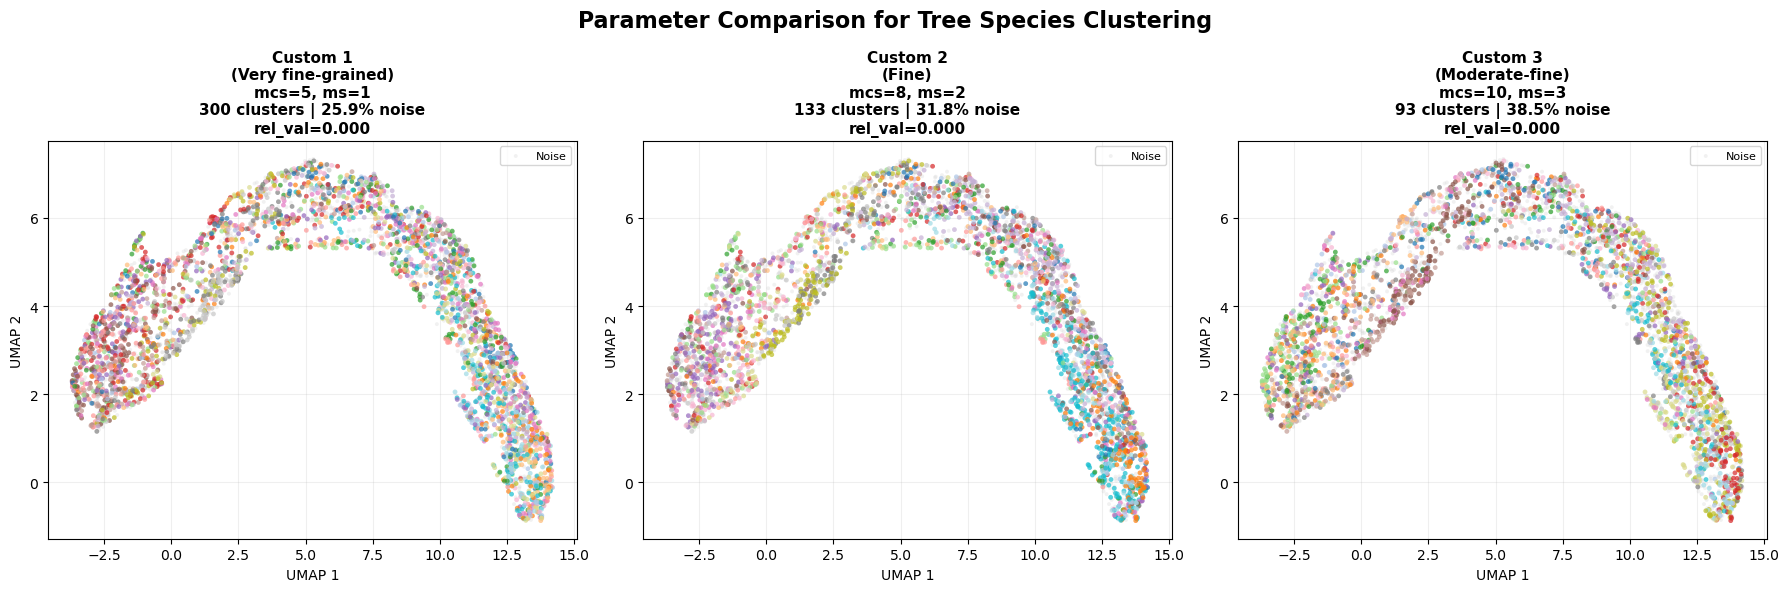

In [61]:
# ============= Visual Comparison of Top Candidates =============

# Collect all winners
candidates_to_visualize = []

if strategy1_params:
    candidates_to_visualize.append({
        'params': (strategy1_params['min_cluster_size'], strategy1_params['min_samples']),
        'label': f"Strategy 1\n(Most clusters)",
        'data': strategy1_params
    })

if strategy2_params:
    candidates_to_visualize.append({
        'params': (strategy2_params['min_cluster_size'], strategy2_params['min_samples']),
        'label': f"Strategy 2\n(Target {target_clusters})",
        'data': strategy2_params
    })

# Add top 3 from custom tests
for i, result in enumerate(custom_results_sorted[:3]):
    candidates_to_visualize.append({
        'params': (result['min_cluster_size'], result['min_samples']),
        'label': f"Custom {i+1}\n({result['description']})",
        'data': result,
        'clusters': result.get('clusters')  # Already computed
    })

# Ensure we have at most 6 for a nice grid
candidates_to_visualize = candidates_to_visualize[:6]

print(f"\nVisualizing {len(candidates_to_visualize)} candidate parameter sets...")

# Create comparison plot
n_plots = len(candidates_to_visualize)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for idx, candidate in enumerate(candidates_to_visualize):
    mcs, ms = candidate['params']
    
    # Use pre-computed clusters if available, otherwise compute
    if 'clusters' in candidate and candidate['clusters'] is not None:
        clusters = candidate['clusters']
    else:
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=mcs,
            min_samples=ms,
            cluster_selection_method='eom'
        )
        clusters = clusterer.fit_predict(reduced_features)
    
    data = candidate['data']
    n_clusters = data['n_clusters']
    n_noise = data['n_noise']
    noise_pct = data['noise_pct']
    rel_val = data['rel_validity']
    
    # Plot
    ax = axes[idx]
    
    if n_noise > 0:
        noise_mask = clusters == -1
        ax.scatter(features_2d[noise_mask, 0], features_2d[noise_mask, 1],
                  c='lightgray', s=8, alpha=0.3, edgecolors='none', label='Noise')
    
    if n_clusters > 0:
        cluster_mask = clusters >= 0
        scatter = ax.scatter(features_2d[cluster_mask, 0], features_2d[cluster_mask, 1],
                           c=clusters[cluster_mask], cmap='tab20', s=12, alpha=0.7,
                           edgecolors='none')
    
    ax.set_xlabel("UMAP 1", fontsize=10)
    ax.set_ylabel("UMAP 2", fontsize=10)
    ax.set_title(f"{candidate['label']}\n"
                f"mcs={mcs}, ms={ms}\n"
                f"{n_clusters} clusters | {noise_pct:.1f}% noise\n"
                f"rel_val={rel_val:.3f}",
                fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.2)
    if n_noise > 0:
        ax.legend(loc='upper right', fontsize=8)

# Hide extra subplots
for idx in range(n_plots, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Parameter Comparison for Tree Species Clustering', 
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "species_parameter_comparison.png", dpi=150, bbox_inches='tight')
print(f"✓ Saved comparison plot: {OUTPUT_DIR / 'species_parameter_comparison.png'}")

if USE_WANDB:
    wandb.init(project="intreeligent-clustering", name="hdbscan-params-selection", reinit=True)
    wandb.log({"parameter_comparison": wandb.Image(fig)})

plt.show()
plt.close()

In [62]:
# ============= Final Recommendations =============

# Score each strategy based on cluster count, noise, and validity
recommendations = []

if strategy1_params:
    score = strategy1_params['rel_validity'] * (1 - strategy1_params['noise_pct']/100) * min(strategy1_params['n_clusters']/20, 1)
    recommendations.append({
        'strategy': 'Strategy 1 (Most clusters in range)',
        'params': strategy1_params,
        'score': score
    })

if strategy2_params:
    score = strategy2_params['rel_validity'] * (1 - strategy2_params['noise_pct']/100) * 1.1  # Bonus for hitting target
    recommendations.append({
        'strategy': f'Strategy 2 (Target {target_clusters} clusters)',
        'params': strategy2_params,
        'score': score
    })

score = strategy3_params['rel_validity'] * (1 - strategy3_params['noise_pct']/100) * min(strategy3_params['n_clusters']/20, 1)
recommendations.append({
    'strategy': f'Strategy 3 ({strategy3_params["description"]})',
    'params': strategy3_params,
    'score': score
})

# Sort by score
recommendations_sorted = sorted(recommendations, key=lambda x: x['score'], reverse=True)

print("\nRanked by composite score (validity × low_noise × cluster_diversity):\n")
for rank, rec in enumerate(recommendations_sorted, 1):
    params = rec['params']
    print(f"{rank}. {rec['strategy']}")
    print(f"   Parameters: min_cluster_size={params['min_cluster_size']}, min_samples={params['min_samples']}")
    print(f"   Results: {params['n_clusters']} clusters, {params['noise_pct']:.1f}% noise")
    print(f"   Quality: rel_validity={params['rel_validity']:.3f}, composite_score={rec['score']:.3f}")
    print()

# THE WINNER
best_recommendation = recommendations_sorted[0]
best_final_params = best_recommendation['params']

print("="*90)
print("🏆 RECOMMENDED PARAMETERS FOR SPECIES CLUSTERING:")
print("="*90)
print(f"  min_cluster_size = {best_final_params['min_cluster_size']}")
print(f"  min_samples = {best_final_params['min_samples']}")
print(f"\n  Expected results:")
print(f"    • {best_final_params['n_clusters']} clusters (likely species groups)")
print(f"    • {best_final_params['noise_pct']:.1f}% noise points (outliers/rare species)")
print(f"    • Relative validity: {best_final_params['rel_validity']:.3f}")
print("="*90)



Ranked by composite score (validity × low_noise × cluster_diversity):

1. Strategy 3 (Very fine-grained)
   Parameters: min_cluster_size=5, min_samples=1
   Results: 300 clusters, 25.9% noise
   Quality: rel_validity=0.000, composite_score=0.000

🏆 RECOMMENDED PARAMETERS FOR SPECIES CLUSTERING:
  min_cluster_size = 5
  min_samples = 1

  Expected results:
    • 300 clusters (likely species groups)
    • 25.9% noise points (outliers/rare species)
    • Relative validity: 0.000


Running final clustering...


/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✓ Final clustering complete!
✓ Saved to: clustering_results_hdbscan-less-strict/clusters_species_optimized.npy
✓ Saved final visualization: clustering_results_hdbscan-less-strict/final_species_clustering.png


final/min_cluster_size,▁
final/min_samples,▁
final/n_clusters,▁
final/n_noise,▁
final/min_cluster_size,5
final/min_samples,1
final/n_clusters,300
final/n_noise,1108


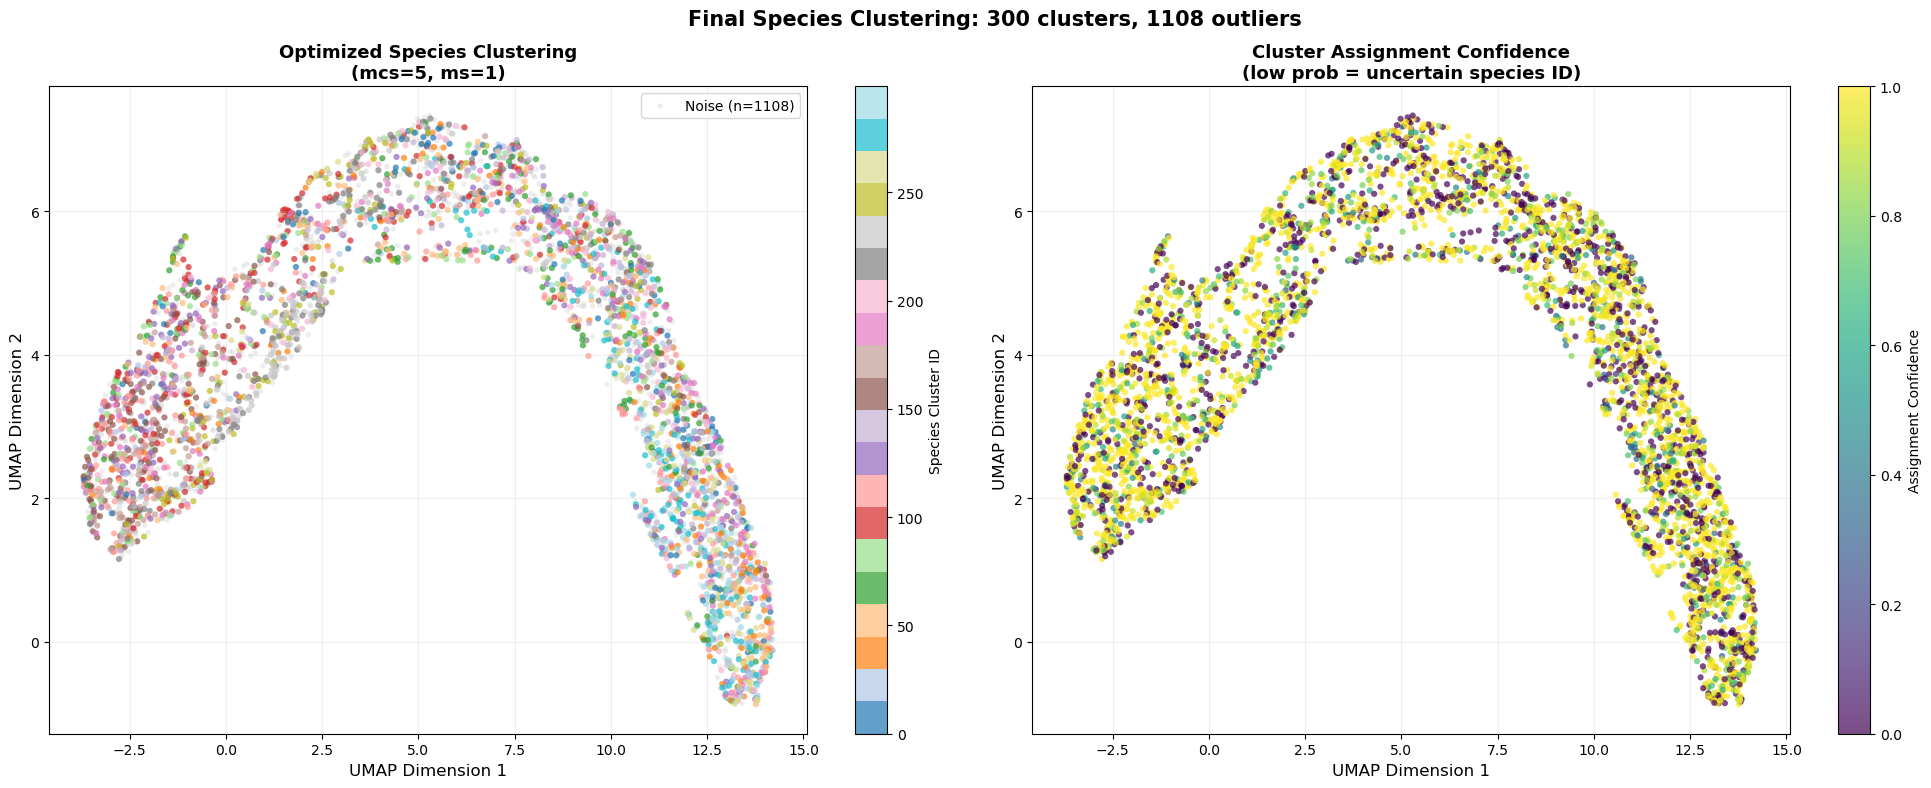

In [63]:
# ============= Generate Final Clustering with Recommended Parameters =============
final_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=best_final_params['min_cluster_size'],
    min_samples=best_final_params['min_samples'],
    cluster_selection_method='eom',
    prediction_data=True,
    gen_min_span_tree=True  # Enable tree for visualization
)

print("Running final clustering...")
final_clusters = final_clusterer.fit_predict(reduced_features)
final_probabilities = final_clusterer.probabilities_

# Save final results
np.save(OUTPUT_DIR / "clusters_species_optimized.npy", final_clusters)
np.save(OUTPUT_DIR / "probabilities_species_optimized.npy", final_probabilities)

print("✓ Final clustering complete!")
print(f"✓ Saved to: {OUTPUT_DIR / 'clusters_species_optimized.npy'}")

# Final visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Left: Clusters
ax = axes[0]
n_clusters_final = len(set(final_clusters)) - (1 if -1 in final_clusters else 0)
n_noise_final = list(final_clusters).count(-1)

if n_noise_final > 0:
    noise_mask = final_clusters == -1
    ax.scatter(features_2d[noise_mask, 0], features_2d[noise_mask, 1],
              c='lightgray', s=15, alpha=0.4, label=f'Noise (n={n_noise_final})', 
              edgecolors='none')

if n_clusters_final > 0:
    cluster_mask = final_clusters >= 0
    scatter = ax.scatter(features_2d[cluster_mask, 0], features_2d[cluster_mask, 1],
                        c=final_clusters[cluster_mask], cmap='tab20', s=20, alpha=0.7, 
                        edgecolors='none')
    cbar = plt.colorbar(scatter, ax=ax, label="Species Cluster ID")

ax.set_xlabel("UMAP Dimension 1", fontsize=12)
ax.set_ylabel("UMAP Dimension 2", fontsize=12)
ax.set_title(f"Optimized Species Clustering\n"
            f"(mcs={best_final_params['min_cluster_size']}, ms={best_final_params['min_samples']})", 
            fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.2)

# Right: Probabilities
ax = axes[1]
scatter = ax.scatter(features_2d[:, 0], features_2d[:, 1],
                    c=final_probabilities, cmap='viridis', s=20, alpha=0.7, 
                    edgecolors='none', vmin=0, vmax=1)
cbar = plt.colorbar(scatter, ax=ax, label="Assignment Confidence")

ax.set_xlabel("UMAP Dimension 1", fontsize=12)
ax.set_ylabel("UMAP Dimension 2", fontsize=12)
ax.set_title(f"Cluster Assignment Confidence\n(low prob = uncertain species ID)", 
            fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.2)

plt.suptitle(f"Final Species Clustering: {n_clusters_final} clusters, {n_noise_final} outliers", 
            fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "final_species_clustering.png", dpi=150)
print(f"✓ Saved final visualization: {OUTPUT_DIR / 'final_species_clustering.png'}")

if USE_WANDB:
    wandb.log({
        "final/clustering": wandb.Image(fig),
        "final/n_clusters": n_clusters_final,
        "final/n_noise": n_noise_final,
        "final/min_cluster_size": best_final_params['min_cluster_size'],
        "final/min_samples": best_final_params['min_samples'],
    })
    wandb.finish()

plt.show()
plt.close()


In [65]:
# ============= Cluster Statistics =============
if n_clusters_final > 0:
    cluster_sizes = np.bincount(final_clusters[final_clusters >= 0])
    
    print("\nFinal Cluster Statistics:")
    print(f"{'Cluster':>8} {'Size':>8} {'Avg Prob':>10} {'Interpretation':>30}")
    print("-"*70)
    
    for i in range(n_clusters_final):
        size = cluster_sizes[i]
        avg_prob = final_probabilities[final_clusters == i].mean()
        
        # Interpretation based on size
        if size > 500:
            interp = "Common species"
        elif size > 200:
            interp = "Moderately common"
        elif size > 50:
            interp = "Less common species"
        else:
            interp = "Rare species / subspecies"
        
        print(f"{i:>8} {size:>8} {avg_prob:>10.3f} {interp:>30}")

print("\n" + "="*90)
print("✓ ANALYSIS COMPLETE!")
print("="*90)
print(f"\nNext steps:")
print(f"  1. Review the visualizations in: {OUTPUT_DIR}")
print(f"  2. Use 'clusters_species_optimized.npy' for your species analysis")
print(f"  3. Low probability points may need manual review")
print(f"  4. Consider examining sample images from each cluster to validate species groupings")


Final Cluster Statistics:
 Cluster     Size   Avg Prob                 Interpretation
----------------------------------------------------------------------
       0        5      1.000      Rare species / subspecies
       1        5      1.000      Rare species / subspecies
       2        8      0.977      Rare species / subspecies
       3        5      1.000      Rare species / subspecies
       4        6      0.931      Rare species / subspecies
       5       11      0.936      Rare species / subspecies
       6        5      1.000      Rare species / subspecies
       7        9      0.831      Rare species / subspecies
       8        7      0.912      Rare species / subspecies
       9       12      0.747      Rare species / subspecies
      10        6      0.995      Rare species / subspecies
      11        7      0.965      Rare species / subspecies
      12       11      0.901      Rare species / subspecies
      13       10      0.598      Rare species / subspecies
  